In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "HB-other"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn006961,MGCSHGGRGSKRGNGSGDPDGDCGKYTRYTAEQVEVLEKVFAECPK...,134,1
1,Achn085431,MKSEIAGSLGLTEKQVSGWFCHRRLKDKNSQHGEAPANGRQDRSSG...,395,1
2,Achn133111,MDTILQEHNTQVPARDVLEALAEKFSASEERSGTIVVQMKQVWNWF...,355,1
3,Achn159891,MAAASSFYSPMALRYLPAPYTHRPSVSHLRANLLLPRYPFRRPVVV...,800,1
4,Achn179461,MVESYAVHSEDNNTPPEKSKKRRFKTPSQVEALEKFYSEHKYPSEE...,493,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
3425,0.000000,0.004132,0.000000,0.008264,0.000000,0.004132,0.000000,0.000000,0.012397,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1948,0.013841,0.000000,0.003460,0.006920,0.006920,0.006920,0.003460,0.006920,0.003460,0.000000,...,0.000000,0.003460,0.000000,0.000000,0.003460,0.000000,0.0,0.0,0.0,0.0
3413,0.006466,0.000000,0.002155,0.002155,0.002155,0.002155,0.000000,0.004310,0.000000,0.002155,...,0.002155,0.000000,0.002155,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3052,0.005682,0.008523,0.005682,0.005682,0.002841,0.000000,0.002841,0.000000,0.000000,0.002841,...,0.000000,0.002841,0.002841,0.005682,0.000000,0.002841,0.0,0.0,0.0,0.0
4391,0.003115,0.003115,0.003115,0.009346,0.000000,0.000000,0.000000,0.012461,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.003115,0.000000,0.0,0.0,0.0,0.0


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3616, 441)
X_test: (904, 441)
y_train: (3616,)
y_test: (904,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 31s 692ms/step - accuracy: 0.4219 - loss: 0.6933

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5150 - loss: 0.6925   

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5478 - loss: 0.6897 - val_accuracy: 0.7749 - val_loss: 0.6246


Epoch 2/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8125 - loss: 0.6135

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7960 - loss: 0.5764 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8011 - loss: 0.5380 - val_accuracy: 0.8508 - val_loss: 0.3513


Epoch 3/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9375 - loss: 0.2649

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8807 - loss: 0.3184 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8810 - loss: 0.3116 - val_accuracy: 0.8384 - val_loss: 0.3880


Epoch 4/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8125 - loss: 0.4599

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8810 - loss: 0.3012 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8880 - loss: 0.2838 - val_accuracy: 0.8840 - val_loss: 0.2989


Epoch 5/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9375 - loss: 0.2241

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9225 - loss: 0.2254 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9229 - loss: 0.2221 - val_accuracy: 0.8771 - val_loss: 0.2867


Epoch 6/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9375 - loss: 0.1647

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9290 - loss: 0.1945 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9318 - loss: 0.1884 - val_accuracy: 0.9033 - val_loss: 0.2521


Epoch 7/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9375 - loss: 0.2293

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9464 - loss: 0.1597 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9451 - loss: 0.1587 - val_accuracy: 0.9075 - val_loss: 0.2394


Epoch 8/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0530

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9486 - loss: 0.1568 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9488 - loss: 0.1547 - val_accuracy: 0.9102 - val_loss: 0.2309


Epoch 9/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9375 - loss: 0.2125

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9457 - loss: 0.1551 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9488 - loss: 0.1481 - val_accuracy: 0.9061 - val_loss: 0.2689


Epoch 10/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9531 - loss: 0.1359

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9448 - loss: 0.1442 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9486 - loss: 0.1375 - val_accuracy: 0.9130 - val_loss: 0.2387


Epoch 11/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0330

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9600 - loss: 0.1170 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9603 - loss: 0.1151 - val_accuracy: 0.9061 - val_loss: 0.2652


Epoch 12/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.0809

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9696 - loss: 0.0917 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9684 - loss: 0.0975 - val_accuracy: 0.9185 - val_loss: 0.2360


Epoch 13/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0458

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9740 - loss: 0.0822 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9719 - loss: 0.0856 - val_accuracy: 0.9268 - val_loss: 0.2172


Epoch 14/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.1053

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9701 - loss: 0.0927 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9680 - loss: 0.0957 - val_accuracy: 0.8826 - val_loss: 0.3355


Epoch 15/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.0503

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9596 - loss: 0.1108 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9637 - loss: 0.0999 - val_accuracy: 0.9130 - val_loss: 0.2825


Epoch 16/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0256

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9826 - loss: 0.0618 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9827 - loss: 0.0602 - val_accuracy: 0.9282 - val_loss: 0.2361


Epoch 17/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0182

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9888 - loss: 0.0328 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9874 - loss: 0.0370 - val_accuracy: 0.9227 - val_loss: 0.2432


Epoch 18/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0171

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0219 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0248 - val_accuracy: 0.8964 - val_loss: 0.3585


Epoch 19/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9688 - loss: 0.0594

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9888 - loss: 0.0323 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0289 - val_accuracy: 0.9227 - val_loss: 0.2690


Epoch 20/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0102

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0131 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0131 - val_accuracy: 0.9185 - val_loss: 0.3080


Epoch 21/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0054

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0199 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0201 - val_accuracy: 0.9185 - val_loss: 0.3259


Epoch 22/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0020

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0161 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0172 - val_accuracy: 0.9296 - val_loss: 0.2845


Epoch 23/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0085

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9797 - loss: 0.0417 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9833 - loss: 0.0364 - val_accuracy: 0.9102 - val_loss: 0.3701


Epoch 24/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0474

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9870 - loss: 0.0334 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9899 - loss: 0.0271 - val_accuracy: 0.9337 - val_loss: 0.2927


Epoch 25/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0021

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0094 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0099 - val_accuracy: 0.9282 - val_loss: 0.2934


Epoch 26/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0033

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0056 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0068 - val_accuracy: 0.9047 - val_loss: 0.4733


Epoch 27/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0122

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0143 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0132 - val_accuracy: 0.9365 - val_loss: 0.3150


Epoch 28/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0018

22/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0083 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.0099 - val_accuracy: 0.9130 - val_loss: 0.3907


Epoch 29/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0062

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0030 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9254 - val_loss: 0.3687


Epoch 30/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0016

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0015 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9213 - val_loss: 0.4398


Epoch 31/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 5.2698e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0036     

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0063 - val_accuracy: 0.9268 - val_loss: 0.3445


Epoch 32/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0036

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0136 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0165 - val_accuracy: 0.8950 - val_loss: 0.4724


Epoch 33/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0271

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0124 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0115 - val_accuracy: 0.9282 - val_loss: 0.3444


Epoch 34/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 5.6715e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0031     

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0030 - val_accuracy: 0.9254 - val_loss: 0.3938


Epoch 35/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 6.9921e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0019     

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0022 - val_accuracy: 0.9378 - val_loss: 0.3445


Epoch 36/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0142

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0089 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0085 - val_accuracy: 0.9337 - val_loss: 0.3501


Epoch 37/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 5.7754e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0026     

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0034 - val_accuracy: 0.9337 - val_loss: 0.3466


Epoch 38/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 8.3397e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0094     

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0108 - val_accuracy: 0.9268 - val_loss: 0.3675


Epoch 39/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0024

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9881 - loss: 0.0382 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0376 - val_accuracy: 0.9185 - val_loss: 0.3663


Epoch 40/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 7.4178e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9913 - loss: 0.0195     

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0182 - val_accuracy: 0.9351 - val_loss: 0.3175


Epoch 41/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 8.3288e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0016     

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0025 - val_accuracy: 0.9185 - val_loss: 0.3751


Epoch 42/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0011

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0019 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 0.9309 - val_loss: 0.3641


Epoch 43/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.6271e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.3870e-04 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.0183e-04 - val_accuracy: 0.9309 - val_loss: 0.3800


Epoch 44/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0043

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0012 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9144 - val_loss: 0.4623


Epoch 45/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0013

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0029 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0024 - val_accuracy: 0.9365 - val_loss: 0.3755



[Train Accuracy: 99.93% - Test Accuracy: 92.92%]


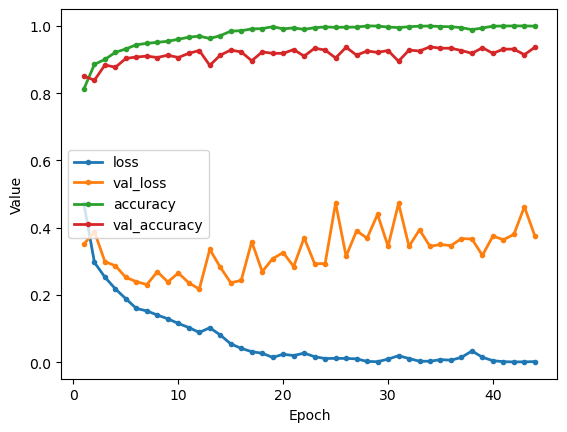

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
3425,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1948,0.00000,0.0,0.0,0.0,0.000000,0.0,0.003472,0.003472,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3413,0.00216,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.002160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3052,0.00000,0.0,0.0,0.0,0.002849,0.0,0.000000,0.000000,0.0,0.002849,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4391,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3616, 8722)
X_test: (904, 8722)
y_train: (3616,)
y_test: (904,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,233,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,276,353 (8.68 MB)

 Trainable params: 2,276,353 (8.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 29s 647ms/step - accuracy: 0.4531 - loss: 0.6931

 7/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4858 - loss: 0.6931   

14/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5025 - loss: 0.6930

21/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5233 - loss: 0.6926

28/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5406 - loss: 0.6920

35/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5604 - loss: 0.6909

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5836 - loss: 0.6885

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5944 - loss: 0.6868 - val_accuracy: 0.9227 - val_loss: 0.5329


Epoch 2/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8906 - loss: 0.5282

 8/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9169 - loss: 0.4955 

15/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9211 - loss: 0.4614

22/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9243 - loss: 0.4279

29/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9256 - loss: 0.4014

36/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9267 - loss: 0.3787

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9284 - loss: 0.3563

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9289 - loss: 0.3491 - val_accuracy: 0.9434 - val_loss: 0.1527


Epoch 3/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9844 - loss: 0.1132

 8/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9878 - loss: 0.0778 

15/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9875 - loss: 0.0676

22/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9877 - loss: 0.0630

30/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9877 - loss: 0.0601

38/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9874 - loss: 0.0583

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9874 - loss: 0.0566

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9873 - loss: 0.0563 - val_accuracy: 0.9558 - val_loss: 0.1511


Epoch 4/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0098

 8/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9983 - loss: 0.0189 

15/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9965 - loss: 0.0213

23/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9959 - loss: 0.0216

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9958 - loss: 0.0215

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9956 - loss: 0.0220

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9953 - loss: 0.0225 - val_accuracy: 0.9544 - val_loss: 0.1620


Epoch 5/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0032

 8/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9856 - loss: 0.0338 

15/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9842 - loss: 0.0371

23/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9849 - loss: 0.0369

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9860 - loss: 0.0357

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9871 - loss: 0.0340

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9880 - loss: 0.0327 - val_accuracy: 0.9558 - val_loss: 0.1764


Epoch 6/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0083

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0048 

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0042

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0041

32/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0041

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0044

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 0.0047 - val_accuracy: 0.9489 - val_loss: 0.2084


Epoch 7/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0021

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0025 

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0024

24/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0023

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0022

38/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0022

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0023

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 0.0024 - val_accuracy: 0.9503 - val_loss: 0.2164


Epoch 8/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0014

 8/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0014 

16/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0015

23/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0016

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0016

38/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0018

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0019

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 0.0019 - val_accuracy: 0.9530 - val_loss: 0.2095


Epoch 9/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0012

 5/46 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9986 - loss: 0.0037

11/46 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9980 - loss: 0.0046

18/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9980 - loss: 0.0045

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9981 - loss: 0.0042 

32/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9983 - loss: 0.0039

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9985 - loss: 0.0037

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9986 - loss: 0.0035 - val_accuracy: 0.9544 - val_loss: 0.2304


Epoch 10/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 7.5144e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.3806e-04 

15/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4942e-04

23/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 8.9174e-04

30/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 9.9116e-04

37/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0010    

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0010

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0011 - val_accuracy: 0.9544 - val_loss: 0.2319


Epoch 11/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 4.4519e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8153e-04 

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4472e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0012    

32/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0014

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0016

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 0.9489 - val_loss: 0.2582


Epoch 12/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.6443e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9983 - loss: 0.0032     

16/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9982 - loss: 0.0037

23/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9983 - loss: 0.0037

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9984 - loss: 0.0037

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9986 - loss: 0.0035

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9987 - loss: 0.0033 - val_accuracy: 0.9503 - val_loss: 0.2554


Epoch 13/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.1339e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3537e-04 

16/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3833e-04

23/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4669e-04

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4539e-04

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3980e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.3540e-04 - val_accuracy: 0.9544 - val_loss: 0.2412



[Train Accuracy: 100.00% - Test Accuracy: 95.35%]


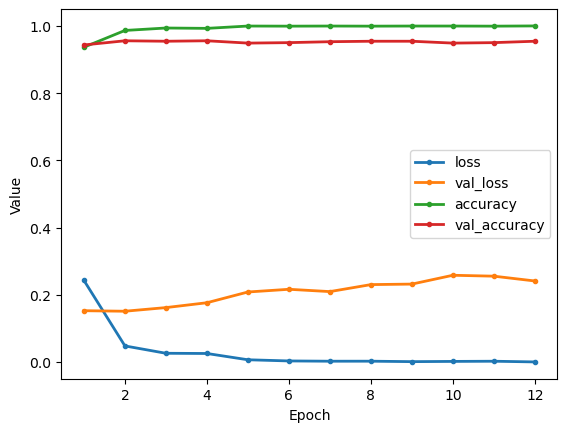

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYW,YYYX,YYYY
3425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002165,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      36,631,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,673,025 (139.90 MB)

 Trainable params: 36,673,025 (139.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 38s 864ms/step - accuracy: 0.5781 - loss: 0.6931

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.5547 - loss: 0.6932 

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.5521 - loss: 0.6931

 4/46 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.5459 - loss: 0.6931

 5/46 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.5423 - loss: 0.6930

 6/46 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.5422 - loss: 0.6928

 7/46 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.5403 - loss: 0.6928

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.5392 - loss: 0.6927

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.5372 - loss: 0.6927

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5353 - loss: 0.6927

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5333 - loss: 0.6927

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.5306 - loss: 0.6927

13/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.5283 - loss: 0.6927

14/46 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5266 - loss: 0.6926

15/46 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5248 - loss: 0.6926

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.5231 - loss: 0.6926

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.5220 - loss: 0.6925

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.5209 - loss: 0.6924

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.5200 - loss: 0.6923

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.5197 - loss: 0.6922

21/46 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.5191 - loss: 0.6921

22/46 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.5188 - loss: 0.6920

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5188 - loss: 0.6918

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5187 - loss: 0.6916

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5187 - loss: 0.6915

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5188 - loss: 0.6912

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5189 - loss: 0.6910

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5191 - loss: 0.6908

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5194 - loss: 0.6905

30/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5197 - loss: 0.6903

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.5201 - loss: 0.6900

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.5208 - loss: 0.6897

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.5215 - loss: 0.6894

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.5225 - loss: 0.6890

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.5235 - loss: 0.6887

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.5246 - loss: 0.6883

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.5257 - loss: 0.6879

38/46 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.5270 - loss: 0.6875

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.5283 - loss: 0.6871

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.5296 - loss: 0.6866

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.5310 - loss: 0.6861

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5325 - loss: 0.6856

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5340 - loss: 0.6851

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5356 - loss: 0.6845

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5371 - loss: 0.6839

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5387 - loss: 0.6834

46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.5402 - loss: 0.6828 - val_accuracy: 0.8343 - val_loss: 0.5262


Epoch 2/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 11s 247ms/step - accuracy: 0.8906 - loss: 0.4983

 2/46 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.8945 - loss: 0.4916 

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.8863 - loss: 0.4899

 4/46 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.8825 - loss: 0.4880

 5/46 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.8804 - loss: 0.4840

 6/46 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.8808 - loss: 0.4787

 7/46 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.8825 - loss: 0.4725

 8/46 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.8840 - loss: 0.4673

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.8853 - loss: 0.4624

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.8868 - loss: 0.4581

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.8883 - loss: 0.4542

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.8897 - loss: 0.4510

13/46 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.8911 - loss: 0.4480

14/46 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.8927 - loss: 0.4450

15/46 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.8944 - loss: 0.4419

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.8960 - loss: 0.4390

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.8977 - loss: 0.4360

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.8992 - loss: 0.4329

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9008 - loss: 0.4299

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9021 - loss: 0.4270

21/46 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9034 - loss: 0.4240

22/46 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9047 - loss: 0.4210

23/46 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9059 - loss: 0.4179

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9071 - loss: 0.4149

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9082 - loss: 0.4119

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9092 - loss: 0.4089

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9102 - loss: 0.4060

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9112 - loss: 0.4030

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9121 - loss: 0.4000

30/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9131 - loss: 0.3971

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9140 - loss: 0.3942

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9149 - loss: 0.3912

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9157 - loss: 0.3883

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9166 - loss: 0.3854

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9174 - loss: 0.3825

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9183 - loss: 0.3796

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9191 - loss: 0.3768

38/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9199 - loss: 0.3740

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9206 - loss: 0.3712

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9214 - loss: 0.3684

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9221 - loss: 0.3657

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9228 - loss: 0.3630

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9235 - loss: 0.3604

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9241 - loss: 0.3578

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9248 - loss: 0.3553

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9254 - loss: 0.3528

46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9260 - loss: 0.3504 - val_accuracy: 0.9669 - val_loss: 0.1118


Epoch 3/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 1.0000 - loss: 0.0305

 2/46 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 0.0266

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 0.0259

 4/46 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 0.0257

 5/46 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9994 - loss: 0.0262

 6/46 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9990 - loss: 0.0262

 7/46 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9989 - loss: 0.0259

 8/46 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9983 - loss: 0.0269

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9979 - loss: 0.0274

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9976 - loss: 0.0276

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9975 - loss: 0.0276

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9973 - loss: 0.0275

13/46 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9973 - loss: 0.0273

14/46 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9971 - loss: 0.0271

15/46 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9971 - loss: 0.0270

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9970 - loss: 0.0268

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9970 - loss: 0.0265

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9969 - loss: 0.0263

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9968 - loss: 0.0261

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9968 - loss: 0.0259

21/46 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9967 - loss: 0.0258

22/46 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9967 - loss: 0.0257

23/46 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9967 - loss: 0.0256

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9966 - loss: 0.0255

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9966 - loss: 0.0253

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9966 - loss: 0.0252

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9966 - loss: 0.0250

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9966 - loss: 0.0249

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9966 - loss: 0.0247

30/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9966 - loss: 0.0246

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9966 - loss: 0.0245

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9965 - loss: 0.0244

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9965 - loss: 0.0243

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9965 - loss: 0.0242

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9965 - loss: 0.0241

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9965 - loss: 0.0240

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9965 - loss: 0.0239

38/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9965 - loss: 0.0238

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9965 - loss: 0.0237

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9965 - loss: 0.0236

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9965 - loss: 0.0235

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9965 - loss: 0.0234

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9965 - loss: 0.0233

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9965 - loss: 0.0232

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9965 - loss: 0.0231

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9965 - loss: 0.0229

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.9965 - loss: 0.0228 - val_accuracy: 0.9337 - val_loss: 0.2126


Epoch 4/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.9844 - loss: 0.0316

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9883 - loss: 0.0248

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9905 - loss: 0.0211

 4/46 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9919 - loss: 0.0187

 5/46 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9929 - loss: 0.0170

 6/46 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9936 - loss: 0.0158

 7/46 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9942 - loss: 0.0148

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9947 - loss: 0.0140

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9951 - loss: 0.0133

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9954 - loss: 0.0127

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9957 - loss: 0.0121

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9960 - loss: 0.0116

13/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9962 - loss: 0.0112

14/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9964 - loss: 0.0108

15/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9965 - loss: 0.0105

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9967 - loss: 0.0102

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9968 - loss: 0.0099

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9970 - loss: 0.0097

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9971 - loss: 0.0094

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9972 - loss: 0.0092

21/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9973 - loss: 0.0090

22/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9974 - loss: 0.0089

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9975 - loss: 0.0087

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9975 - loss: 0.0085

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9976 - loss: 0.0085

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9976 - loss: 0.0085

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9977 - loss: 0.0085

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9977 - loss: 0.0084

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9978 - loss: 0.0084

30/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9978 - loss: 0.0083

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9978 - loss: 0.0083

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9979 - loss: 0.0082

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9979 - loss: 0.0082

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9980 - loss: 0.0081

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9980 - loss: 0.0081

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9980 - loss: 0.0080

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9980 - loss: 0.0080

38/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9980 - loss: 0.0080

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9981 - loss: 0.0079

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9981 - loss: 0.0079

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9981 - loss: 0.0079

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9981 - loss: 0.0078

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9981 - loss: 0.0078

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9981 - loss: 0.0078

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9981 - loss: 0.0078

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9982 - loss: 0.0078

46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.9982 - loss: 0.0078 - val_accuracy: 0.9641 - val_loss: 0.0937


Epoch 5/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 1.0000 - loss: 0.0021

 2/46 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 0.0020

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 0.0019

 4/46 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 0.0022

 5/46 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0024

 6/46 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 0.0025

 7/46 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 0.0025

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0026

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0025

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0025

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0025

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0025

13/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0025

14/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9999 - loss: 0.0027

15/46 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9999 - loss: 0.0029

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9998 - loss: 0.0031

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9998 - loss: 0.0032

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9997 - loss: 0.0033

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9997 - loss: 0.0034

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9997 - loss: 0.0035

21/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9997 - loss: 0.0035

22/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9996 - loss: 0.0035

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9996 - loss: 0.0036

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9996 - loss: 0.0036

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9996 - loss: 0.0036

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9996 - loss: 0.0036

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9996 - loss: 0.0037

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9995 - loss: 0.0037

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9995 - loss: 0.0038

30/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9995 - loss: 0.0039

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9995 - loss: 0.0039

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9995 - loss: 0.0039

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9995 - loss: 0.0040

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9994 - loss: 0.0040

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9994 - loss: 0.0040

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9994 - loss: 0.0040

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9994 - loss: 0.0041

38/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9994 - loss: 0.0041

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9994 - loss: 0.0041

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9993 - loss: 0.0041

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9993 - loss: 0.0041

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9993 - loss: 0.0041

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9993 - loss: 0.0041

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9993 - loss: 0.0041

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9993 - loss: 0.0041

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9993 - loss: 0.0041

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.9993 - loss: 0.0041 - val_accuracy: 0.9655 - val_loss: 0.0967


Epoch 6/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 8.6038e-04

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 8.1850e-04

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 8.6304e-04

 4/46 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.1879e-04

 5/46 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 9.5135e-04

 6/46 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 9.7842e-04

 7/46 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 9.8725e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 9.9613e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0010    

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0010

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0010

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0011

13/46 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0011

14/46 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0011

15/46 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0011

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0011

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 0.0011

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 0.0011

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 0.0011

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 0.0011

21/46 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 0.0011

22/46 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 0.0011

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 0.0011

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 0.0011

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 0.0011

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 0.0011

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 0.0011

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 0.0011

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 0.0011

30/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 0.0011

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0011

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0011

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0011

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0011

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0011

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0010

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0010

38/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0011

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0011

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0011

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0011

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0011

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9999 - loss: 0.0011

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9999 - loss: 0.0011

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9999 - loss: 0.0011

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9999 - loss: 0.0011

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 0.9641 - val_loss: 0.0962


Epoch 7/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 4.5285e-04

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 4.4017e-04

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.8862e-04

 4/46 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.9121e-04

 5/46 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 4.9711e-04

 6/46 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.9926e-04

 7/46 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.9768e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.9493e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.9294e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.9021e-04

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.8726e-04

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.8559e-04

13/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.8454e-04

14/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.8342e-04

15/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.8284e-04

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 4.8202e-04

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 4.8258e-04

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 4.8249e-04

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 4.8194e-04

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 4.8149e-04

21/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 4.8041e-04

22/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 4.7918e-04

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 4.8392e-04

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 4.8807e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 4.9150e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 4.9739e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 5.0250e-04

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 5.0688e-04

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 5.1066e-04

30/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 5.1466e-04

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 5.1812e-04

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 5.2133e-04

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 5.2415e-04

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 5.2688e-04

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 5.2940e-04

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 5.3149e-04

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 5.3317e-04

38/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 5.3449e-04

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 5.3561e-04

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 5.3664e-04

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 5.3749e-04

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 5.3962e-04

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 5.4140e-04

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 5.4294e-04

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 5.5460e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 5.6566e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 5.7626e-04 - val_accuracy: 0.9572 - val_loss: 0.1383


Epoch 8/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 3.0236e-04

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.2923e-04

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.3439e-04

 4/46 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 3.9362e-04

 5/46 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 4.1674e-04

 6/46 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 4.3295e-04

 7/46 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 4.4621e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 5.1909e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 5.7228e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 6.0952e-04

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 6.6855e-04

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 7.1941e-04

13/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 7.5732e-04

14/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 7.8525e-04

15/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 8.0544e-04

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 8.2016e-04

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 8.3070e-04

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 8.3865e-04

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 8.4364e-04

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 8.4647e-04

21/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 8.4724e-04

22/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 8.4697e-04

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.4592e-04

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.4396e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.4114e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 8.3826e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 8.3537e-04

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 8.3207e-04

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 8.2841e-04

30/46 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 8.2457e-04

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 8.2066e-04

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.1655e-04

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 8.1221e-04

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 8.0802e-04

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 8.0452e-04

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 8.0212e-04

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 7.9948e-04

38/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 7.9687e-04

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 7.9424e-04

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 7.9157e-04

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 7.8874e-04

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 7.8574e-04

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 7.8267e-04

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 7.7960e-04

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 7.7647e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 7.7343e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 7.7051e-04 - val_accuracy: 0.9669 - val_loss: 0.1075


Epoch 9/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 3.3334e-04

 2/46 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 3.3978e-04

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 3.2397e-04

 4/46 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.0947e-04

 5/46 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.0140e-04

 6/46 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.0419e-04

 7/46 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.0164e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.0105e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.0032e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 3.0015e-04

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 2.9905e-04

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 2.9736e-04

13/46 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 2.9602e-04

14/46 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 2.9478e-04

15/46 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.9839e-04

16/46 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 3.0130e-04

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 3.0804e-04

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 3.1414e-04

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 3.1919e-04

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 3.2309e-04

21/46 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 3.2644e-04

22/46 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 3.2926e-04

23/46 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 3.3148e-04

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 3.3316e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 3.3448e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 3.3570e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.3649e-04

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.3698e-04

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.3716e-04

30/46 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.3731e-04

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.3724e-04

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.3729e-04

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.3715e-04

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.3711e-04

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.3707e-04

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.3687e-04

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.3662e-04

38/46 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.3629e-04

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 3.3590e-04

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 3.3554e-04

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 3.3511e-04

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 3.3462e-04

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 3.3405e-04

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 3.3346e-04

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 3.3284e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 3.3226e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 3.3171e-04 - val_accuracy: 0.9669 - val_loss: 0.1076


Epoch 10/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.4635e-04

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 2.9936e-04

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.3145e-04

 4/46 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 3.8043e-04

 5/46 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 3.9663e-04

 6/46 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 4.0163e-04

 7/46 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 4.0083e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 3.9591e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 3.8936e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 3.8672e-04

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 3.8272e-04

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 3.7851e-04

13/46 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 3.7421e-04

14/46 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 3.6990e-04

15/46 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 3.6529e-04

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 3.6101e-04

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.5647e-04

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.5211e-04

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 3.4787e-04

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 3.4369e-04

21/46 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.3961e-04

22/46 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.3553e-04

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.3382e-04

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.3206e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.3013e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.2803e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.2640e-04

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.2463e-04

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.2521e-04

30/46 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.2584e-04

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 3.2618e-04

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 3.2627e-04

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 3.2635e-04

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 3.2632e-04

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 3.2619e-04

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 3.2599e-04

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 3.2563e-04

38/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 3.2521e-04

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.2468e-04

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.2405e-04

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.2335e-04

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 3.2257e-04

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 3.2177e-04

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 3.2124e-04

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.2070e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.2018e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 3.1968e-04 - val_accuracy: 0.9669 - val_loss: 0.1157


Epoch 11/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 1.9057e-04

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 1.6907e-04

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.6781e-04

 4/46 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 1.6161e-04

 5/46 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 1.5438e-04

 6/46 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.4740e-04

 7/46 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.4324e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.4234e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 1.4187e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.4119e-04

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.4065e-04

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 1.4160e-04

13/46 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.4234e-04

14/46 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 1.4320e-04

15/46 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 1.4395e-04

16/46 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 1.4441e-04

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.4484e-04

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.4497e-04

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 1.4490e-04

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.4479e-04

21/46 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.4456e-04

22/46 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 1.4436e-04

23/46 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 1.4405e-04

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.4413e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.4406e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.4393e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.4372e-04

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 1.4371e-04

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 1.4360e-04

30/46 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 1.4341e-04

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.4327e-04

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.4311e-04

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.4300e-04

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.4291e-04

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.4276e-04

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.4275e-04

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.4271e-04

38/46 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.4268e-04

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.4269e-04

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.4341e-04

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.4413e-04

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.4478e-04

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.4599e-04

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.4715e-04

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.4818e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.4915e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 1.5008e-04 - val_accuracy: 0.9669 - val_loss: 0.1199


Epoch 12/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 9.2493e-05

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 8.1744e-05

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 7.9486e-05

 4/46 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 8.5099e-05

 5/46 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.0113e-04

 6/46 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.1196e-04

 7/46 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.1757e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.2069e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.2231e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.2288e-04

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 1.2293e-04

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.2270e-04

13/46 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.2219e-04

14/46 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.2160e-04

15/46 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.4668e-04

16/46 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.6722e-04

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.8381e-04

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.9727e-04

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 2.0860e-04

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 2.1799e-04

21/46 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 2.2606e-04

22/46 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 2.3292e-04

23/46 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 2.3876e-04

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 2.4366e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 2.4782e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 2.6793e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 2.8563e-04

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9999 - loss: 3.0162e-04

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9999 - loss: 3.1573e-04

30/46 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9999 - loss: 3.2823e-04

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9999 - loss: 3.3931e-04

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9999 - loss: 3.4910e-04

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9999 - loss: 3.5787e-04

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9999 - loss: 3.6569e-04

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9999 - loss: 3.7261e-04

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9998 - loss: 3.7880e-04

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9998 - loss: 3.8429e-04

38/46 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9998 - loss: 3.8917e-04

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9998 - loss: 3.9353e-04

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9998 - loss: 3.9742e-04

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9998 - loss: 4.0088e-04

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9998 - loss: 4.0390e-04

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9998 - loss: 4.0655e-04

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9998 - loss: 4.0894e-04

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9998 - loss: 4.1099e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9998 - loss: 4.1292e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9998 - loss: 4.1476e-04 - val_accuracy: 0.9613 - val_loss: 0.0970



[Train Accuracy: 99.97% - Test Accuracy: 96.02%]


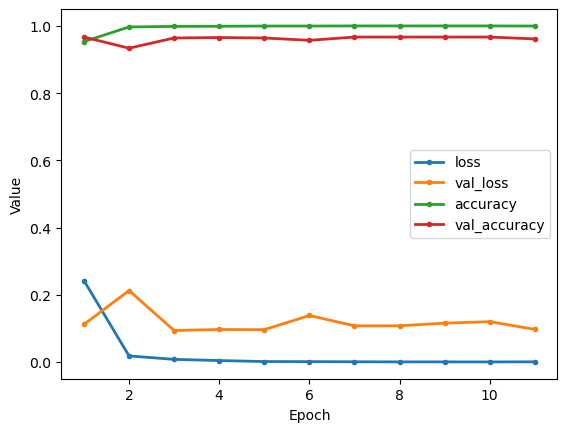

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

 5/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

 9/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

14/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

 5/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

 9/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

14/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [26]:
report.save()

Report saved as Output/Reports/HB-other/report_RDG2GAJ2.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################